Описание задачи:

Визуализировать зависимость дисперсии вариационного распределения от номера слоя в многослойной нейросети. Построить визуализацию для разных априорных распределений: N(0, 10^{-2}), N(0, 10^{-1}), N(0, 1), N(0, 10), N(0, 100). Выборка: MNIST, Fashion-MNIST, CIFAR-10 или любая другая, используемая в DL. Модель: многослойная нейросеть, не менее 3 слоев. Вариационное распределение: нормально с диагональной матрицей ковариаций.

Описание решения:
Сеть для выполнения задачи бралась из https://github.com/JavierAntoran/Bayesian-Neural-Networks , ссылка также была взята из описания к заданию. Нейросеть из этого репозитория трехслойная; этого достаточно для хадания и я не стал это менять, однако при желании(не проверялось на практике) слои можно добавлять, код описания и forward самой сети достаточно простой. Указанный в описании код также поддерживает заданны вид априорного распределения.



Примечание: на то, что выдает код и что где-либо выдало ошибку лучше не смотреть. Код запускался несколько раз и не всегда с разумными параметрами; в какие-то моменты я его прерывал.



In [21]:
#Код выполнялся в колабе в папке,куда было скопировано содержимое репозитория выше. 
#Отсюда несколько странных импортов далее
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/BNN')
#BNN - папка, куда копировался предлагаемый к использованию https://github.com/JavierAntoran/Bayesian-Neural-Networks  код

In [36]:
from __future__ import division, print_function
from tqdm.notebook import tqdm
from scipy import stats
import time
import torch.utils.data
from torchvision import transforms, datasets
import argparse
import matplotlib.pyplot as plt
import torch.nn.functional as F
from statsmodels.distributions.empirical_distribution import ECDF
from src.Bayes_By_Backprop.model import *
from src.Bayes_By_Backprop_Local_Reparametrization.model import *

In [4]:
sigma1 = 0.01
sigma2 = 0.1
sigma3 = 1
sigma4 = 10
sigma5 = 100
#Задаем априорную дисперсию

In [5]:

#Эксперимент и параметры сохранены с репозитория с кода, кроме числа эпох. Выбор числа эпох ничем не обусловлен. 
NTrainPointsMNIST = 60000 
batch_size = 100
nb_epochs = 6
log_interval = 1 
use_cuda = 0

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])
#Часть подготовки данных(1)

In [7]:
#Задаем сеть для каждого требуемого априорного распределения
net1 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma1))
net2= BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma2))
net3 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma3))
net4 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma4))
net5 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma5))


Net:
 Creating Net!! 
    Total params: 4.79M

Net:
 Creating Net!! 
    Total params: 4.79M

Net:
 Creating Net!! 
    Total params: 4.79M

Net:
 Creating Net!! 
    Total params: 4.79M

Net:
 Creating Net!! 
    Total params: 4.79M


In [ ]:
#Часть подготовки данных(2)
trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=2)

In [ ]:
net = net3
# Авторские комментарии на английском. Вторая директория не используется в задании.
# Where to save models weights
models_dir = 'drive/MyDrive/BNN/moddir_3'
# Where to save plots and error, accuracy vectors
results_dir = 'drive/MyDrive/BNN/resdir_3'

mkdir(models_dir)
mkdir(results_dir)

epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')


Train:
  init cost variables:


  0%|          | 0/600 [00:00<?, ?it/s]

it 0/6, Jtr_KL = 81.692667, Jtr_pred = 1.720268, err = 0.280750,    time: 1209.516476 seconds

    Jdev = 0.391863, err = 0.115300

best test error
Writting drive/MyDrive/BNN/moddir_3/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 1/6, Jtr_KL = 81.657917, Jtr_pred = 0.501663, err = 0.142717,    time: 625.851542 seconds

    Jdev = 0.280161, err = 0.078900

best test error
Writting drive/MyDrive/BNN/moddir_3/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 2/6, Jtr_KL = 81.622175, Jtr_pred = 0.398197, err = 0.113867,    time: 618.099313 seconds

    Jdev = 0.250200, err = 0.073700

best test error
Writting drive/MyDrive/BNN/moddir_3/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 3/6, Jtr_KL = 81.585892, Jtr_pred = 0.338671, err = 0.095517,    time: 618.498785 seconds

    Jdev = 0.191787, err = 0.056500

best test error
Writting drive/MyDrive/BNN/moddir_3/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 4/6, Jtr_KL = 81.550075, Jtr_pred = 0.297214, err = 0.086283,    time: 623.641013 seconds

    Jdev = 0.180192, err = 0.052500

best test error
Writting drive/MyDrive/BNN/moddir_3/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 5/6, Jtr_KL = 81.514000, Jtr_pred = 0.268447, err = 0.077017,    time: 618.188963 seconds

    Jdev = 0.163289, err = 0.049600

best test error
Writting drive/MyDrive/BNN/moddir_3/theta_best.dat

   average time: 721.543582 seconds

Writting drive/MyDrive/BNN/moddir_3/theta_last.dat



In [ ]:
net = net4
# Авторские комментарии на английском. Вторая директория не используется в задании.
# Where to save models weights
models_dir = 'drive/MyDrive/BNN/moddir_4'
# Where to save plots and error, accuracy vectors
results_dir = 'drive/MyDrive/BNN/resdir_4'

mkdir(models_dir)
mkdir(results_dir)

epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')


Train:
  init cost variables:


  0%|          | 0/600 [00:00<?, ?it/s]

it 0/6, Jtr_KL = 173.401933, Jtr_pred = 1.671667, err = 0.276650,    time: 1197.611490 seconds

    Jdev = 0.338538, err = 0.102100

best test error
Writting drive/MyDrive/BNN/moddir_4/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 1/6, Jtr_KL = 173.366000, Jtr_pred = 0.499568, err = 0.140517,    time: 670.867325 seconds

    Jdev = 0.255575, err = 0.075300

best test error
Writting drive/MyDrive/BNN/moddir_4/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 2/6, Jtr_KL = 173.330683, Jtr_pred = 0.390487, err = 0.110467,    time: 689.149138 seconds

    Jdev = 0.203937, err = 0.061400

best test error
Writting drive/MyDrive/BNN/moddir_4/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 3/6, Jtr_KL = 173.293733, Jtr_pred = 0.335616, err = 0.096233,    time: 658.371492 seconds

    Jdev = 0.186809, err = 0.057300

best test error
Writting drive/MyDrive/BNN/moddir_4/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 4/6, Jtr_KL = 173.256017, Jtr_pred = 0.292292, err = 0.083733,    time: 632.612658 seconds

    Jdev = 0.164247, err = 0.049700

best test error
Writting drive/MyDrive/BNN/moddir_4/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 5/6, Jtr_KL = 173.218867, Jtr_pred = 0.263004, err = 0.075733,    time: 618.968629 seconds

    Jdev = 0.155136, err = 0.045900

best test error
Writting drive/MyDrive/BNN/moddir_4/theta_best.dat

   average time: 747.167357 seconds

Writting drive/MyDrive/BNN/moddir_4/theta_last.dat



In [ ]:
net = net5
# Авторские комментарии на английском. Вторая директория не используется в задании.
# Where to save models weights
models_dir = 'drive/MyDrive/BNN/moddir_5'
# Where to save plots and error, accuracy vectors
results_dir = 'drive/MyDrive/BNN/resdir_5'

mkdir(models_dir)
mkdir(results_dir)

epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')


Train:
  init cost variables:


  0%|          | 0/600 [00:00<?, ?it/s]

it 0/6, Jtr_KL = 265.319617, Jtr_pred = 1.721789, err = 0.281533,    time: 1219.383825 seconds

    Jdev = 0.327537, err = 0.093600

best test error
Writting drive/MyDrive/BNN/moddir_5/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 1/6, Jtr_KL = 265.283967, Jtr_pred = 0.498100, err = 0.142183,    time: 620.847870 seconds

    Jdev = 0.258689, err = 0.071000

best test error
Writting drive/MyDrive/BNN/moddir_5/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 2/6, Jtr_KL = 265.247150, Jtr_pred = 0.394701, err = 0.114383,    time: 622.973984 seconds

    Jdev = 0.212388, err = 0.061900

best test error
Writting drive/MyDrive/BNN/moddir_5/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 3/6, Jtr_KL = 265.210000, Jtr_pred = 0.336322, err = 0.096150,    time: 618.507267 seconds

    Jdev = 0.179194, err = 0.051500

best test error
Writting drive/MyDrive/BNN/moddir_5/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 4/6, Jtr_KL = 265.173217, Jtr_pred = 0.296639, err = 0.082817,    time: 622.952569 seconds

    Jdev = 0.161770, err = 0.047500

best test error
Writting drive/MyDrive/BNN/moddir_5/theta_best.dat



  0%|          | 0/600 [00:00<?, ?it/s]

it 5/6, Jtr_KL = 265.135750, Jtr_pred = 0.266000, err = 0.075983,    time: 624.127430 seconds

    Jdev = 0.144654, err = 0.042300

best test error
Writting drive/MyDrive/BNN/moddir_5/theta_best.dat

   average time: 723.999469 seconds

Writting drive/MyDrive/BNN/moddir_5/theta_last.dat



In [ ]:
net = net2
# Авторские комментарии на английском. Вторая директория не используется в задании.
# Where to save models weights
models_dir = 'drive/MyDrive/BNN/moddir_2'
# Where to save plots and error, accuracy vectors
results_dir = 'drive/MyDrive/BNN/resdir_2'

mkdir(models_dir)
mkdir(results_dir)

epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')


Train:
  init cost variables:


  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
net = net1
# Авторские комментарии на английском. Вторая директория не используется в задании.
# Where to save models weights
models_dir = 'drive/MyDrive/BNN/moddir_1'
# Where to save plots and error, accuracy vectors
results_dir = 'drive/MyDrive/BNN/resdir_1'

mkdir(models_dir)
mkdir(results_dir)
#С этого момента идет никак не измененный(кроме добавления tqdm) авторский код эксперимента. 
#Так как он используется в готовом виде,никаких дополнительных комментариев не даю
#Однако кажется, что в целом все понятно и без них
nsamples = 5
epoch = 0
cprint('c', '\nTrain:')

print('  init cost variables:')
kl_cost_train = np.zeros(nb_epochs)
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
best_err = np.inf

nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    # We draw more samples on the first epoch in order to ensure convergence
    if i == 0:
        ELBO_samples = 10
    else:
        ELBO_samples = nsamples

    net.set_mode_train(True)
    tic = time.time()
    nb_samples = 0

    for x, y in tqdm(trainloader):
        cost_dkl, cost_pred, err = net.fit(x, y, samples=ELBO_samples)

        err_train[i] += err
        kl_cost_train[i] += cost_dkl
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    kl_cost_train[i] /= nb_samples  # Normalise by number of samples in order to get comparable number to the -log like
    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_KL = %f, Jtr_pred = %f, err = %f, " % (
    i, nb_epochs, kl_cost_train[i], pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):
            cost, err, probs = net.eval(x, y)  # This takes the expected weights to save time, not proper inference

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
            net.save(models_dir + '/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)

net.save(models_dir + '/theta_last.dat')

К следующим ячейкам: я воспользовался авторским семплированием и этим путем вычислил $\mu,\sigma$ эмпирически. Конечно, это не очень точно(отсюда возможен знаменатель 10000 а не 9999 в оценке дисперсии) и возможно в авторском коде также был готовый ответ. После этого было построено эмпирическое распределение дисперсии. Данный код работает только для трехслойной версии.

In [39]:
models_dir = 'drive/MyDrive/BNN/moddir_1'
net1.load(models_dir + '/theta_last.dat')
state_dict = net1.model.state_dict()
previous_layer_name = ''
layer1weights = torch.zeros(784,1200)
layer2weights = torch.zeros(1200,1200)
layer3weights = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weights += W_mu + 1 * std_w * eps_W
      if(l == 2):
        layer2weights += W_mu + 1 * std_w * eps_W
      if(l == 3):
        layer3weights += W_mu + 1 * std_w * eps_W
layer1weightsmu = layer1weights/10000
layer2weightsmu = layer2weights/10000
layer3weightsmu = layer3weights/10000
layer1weightssigma = torch.zeros(784,1200)
layer2weightssigma = torch.zeros(1200,1200)
layer3weightssigma = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weightssigma += (W_mu + 1 * std_w * eps_W - layer1weightsmu)*(W_mu + 1 * std_w * eps_W- layer1weightsmu)
      if(l == 2):
        layer2weightssigma += (W_mu + 1 * std_w * eps_W - layer2weightsmu)*(W_mu + 1 * std_w * eps_W- layer2weightsmu)
      if(l == 3):
        layer3weightssigma += (W_mu + 1 * std_w * eps_W - layer3weightsmu)*(W_mu + 1 * std_w * eps_W- layer3weightsmu)
layer1weightssigma = (layer1weightssigma/10000).numpy()
layer2weightssigma = (layer2weightssigma/10000).numpy()
layer3weightssigma = (layer3weightssigma/10000).numpy()
ecdf1 = ECDF(layer1weightssigma)
ecdf2 = ECDF(layer2weightssigma)
ecdf3 = ECDF(layer3weightssigma)
plt.plot(ecdf1.x, ecdf1.y ,label = '1st_layer')
plt.plot(ecdf2.x, ecdf2.y ,label = '2nd_layer')
plt.plot(ecdf3.x, ecdf3.y ,label = '3rd_layer')
plt.title('Эмпирическое распределение дисперсий на слоях, априорно сигма 0.01 ')
plt.xlabel('Значение дисперсии')
plt.legend()
plt.grid()
plt.show()

Reading drive/MyDrive/BNN/moddir_1/theta_last.dat

  restoring epoch: 5, lr: 0.001000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

ValueError: ignored

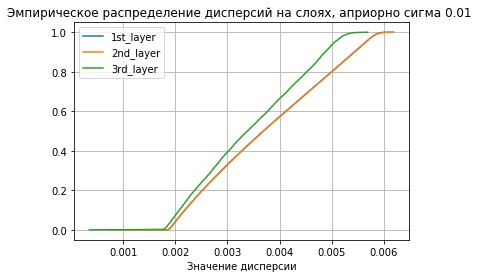

In [43]:
ecdf1 = ECDF(layer1weightssigma.reshape(-1))
ecdf2 = ECDF(layer2weightssigma.reshape(-1))
ecdf3 = ECDF(layer3weightssigma.reshape(-1))
plt.plot(ecdf1.x, ecdf1.y ,label = '1st_layer')
plt.plot(ecdf2.x, ecdf2.y ,label = '2nd_layer')
plt.plot(ecdf3.x, ecdf3.y ,label = '3rd_layer')
plt.title('Эмпирическое распределение дисперсий на слоях, априорно сигма 0.01 ')
plt.xlabel('Значение дисперсии')
plt.legend()
plt.grid()
plt.show()


Net:
 Creating Net!! 
    Total params: 4.79M
Reading drive/MyDrive/BNN/moddir_2/theta_last.dat

  restoring epoch: 5, lr: 0.001000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

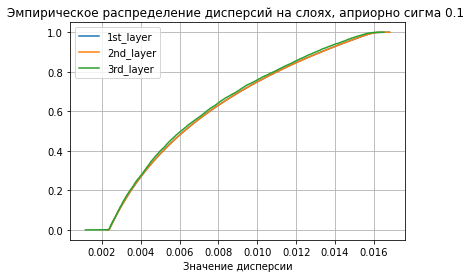

In [44]:
net2 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma2))
models_dir = 'drive/MyDrive/BNN/moddir_2'
net2.load(models_dir + '/theta_last.dat')
state_dict = net2.model.state_dict()
previous_layer_name = ''
layer1weights = torch.zeros(784,1200)
layer2weights = torch.zeros(1200,1200)
layer3weights = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weights += W_mu + 1 * std_w * eps_W
      if(l == 2):
        layer2weights += W_mu + 1 * std_w * eps_W
      if(l == 3):
        layer3weights += W_mu + 1 * std_w * eps_W
layer1weightsmu = layer1weights/10000
layer2weightsmu = layer2weights/10000
layer3weightsmu = layer3weights/10000
layer1weightssigma = torch.zeros(784,1200)
layer2weightssigma = torch.zeros(1200,1200)
layer3weightssigma = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weightssigma += (W_mu + 1 * std_w * eps_W - layer1weightsmu)*(W_mu + 1 * std_w * eps_W- layer1weightsmu)
      if(l == 2):
        layer2weightssigma += (W_mu + 1 * std_w * eps_W - layer2weightsmu)*(W_mu + 1 * std_w * eps_W- layer2weightsmu)
      if(l == 3):
        layer3weightssigma += (W_mu + 1 * std_w * eps_W - layer3weightsmu)*(W_mu + 1 * std_w * eps_W- layer3weightsmu)
layer1weightssigma = (layer1weightssigma/10000).numpy()
layer2weightssigma = (layer2weightssigma/10000).numpy()
layer3weightssigma = (layer3weightssigma/10000).numpy()
ecdf1 = ECDF(layer1weightssigma.reshape(-1))
ecdf2 = ECDF(layer2weightssigma.reshape(-1))
ecdf3 = ECDF(layer3weightssigma.reshape(-1))
plt.plot(ecdf1.x, ecdf1.y ,label = '1st_layer')
plt.plot(ecdf2.x, ecdf2.y ,label = '2nd_layer')
plt.plot(ecdf3.x, ecdf3.y ,label = '3rd_layer')
plt.title('Эмпирическое распределение дисперсий на слоях, априорно сигма 0.1 ')
plt.xlabel('Значение дисперсии')
plt.legend()
plt.grid()
plt.show()


Net:
 Creating Net!! 
    Total params: 4.79M
Reading drive/MyDrive/BNN/moddir_3/theta_last.dat

  restoring epoch: 5, lr: 0.001000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

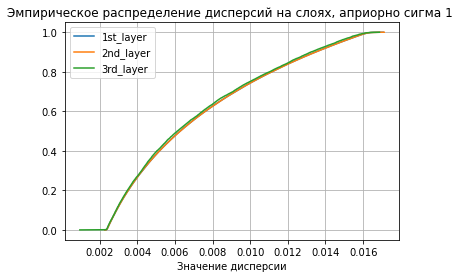

In [45]:
net3 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma3))
models_dir = 'drive/MyDrive/BNN/moddir_3'
net3.load(models_dir + '/theta_last.dat')
state_dict = net3.model.state_dict()
previous_layer_name = ''
layer1weights = torch.zeros(784,1200)
layer2weights = torch.zeros(1200,1200)
layer3weights = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weights += W_mu + 1 * std_w * eps_W
      if(l == 2):
        layer2weights += W_mu + 1 * std_w * eps_W
      if(l == 3):
        layer3weights += W_mu + 1 * std_w * eps_W
layer1weightsmu = layer1weights/10000
layer2weightsmu = layer2weights/10000
layer3weightsmu = layer3weights/10000
layer1weightssigma = torch.zeros(784,1200)
layer2weightssigma = torch.zeros(1200,1200)
layer3weightssigma = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weightssigma += (W_mu + 1 * std_w * eps_W - layer1weightsmu)*(W_mu + 1 * std_w * eps_W- layer1weightsmu)
      if(l == 2):
        layer2weightssigma += (W_mu + 1 * std_w * eps_W - layer2weightsmu)*(W_mu + 1 * std_w * eps_W- layer2weightsmu)
      if(l == 3):
        layer3weightssigma += (W_mu + 1 * std_w * eps_W - layer3weightsmu)*(W_mu + 1 * std_w * eps_W- layer3weightsmu)
layer1weightssigma = (layer1weightssigma/10000).numpy()
layer2weightssigma = (layer2weightssigma/10000).numpy()
layer3weightssigma = (layer3weightssigma/10000).numpy()
ecdf1 = ECDF(layer1weightssigma.reshape(-1))
ecdf2 = ECDF(layer2weightssigma.reshape(-1))
ecdf3 = ECDF(layer3weightssigma.reshape(-1))
plt.plot(ecdf1.x, ecdf1.y ,label = '1st_layer')
plt.plot(ecdf2.x, ecdf2.y ,label = '2nd_layer')
plt.plot(ecdf3.x, ecdf3.y ,label = '3rd_layer')
plt.title('Эмпирическое распределение дисперсий на слоях, априорно сигма 1 ')
plt.xlabel('Значение дисперсии')
plt.legend()
plt.grid()
plt.show()


Net:
 Creating Net!! 
    Total params: 4.79M
Reading drive/MyDrive/BNN/moddir_4/theta_last.dat

  restoring epoch: 5, lr: 0.001000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

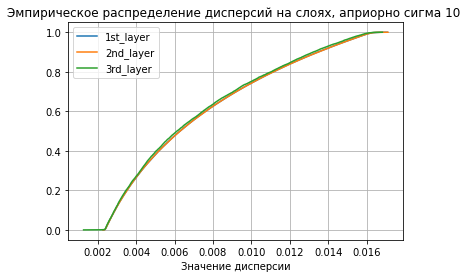

In [46]:
net4 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma4))
models_dir = 'drive/MyDrive/BNN/moddir_4'
net4.load(models_dir + '/theta_last.dat')
state_dict = net4.model.state_dict()
previous_layer_name = ''
layer1weights = torch.zeros(784,1200)
layer2weights = torch.zeros(1200,1200)
layer3weights = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weights += W_mu + 1 * std_w * eps_W
      if(l == 2):
        layer2weights += W_mu + 1 * std_w * eps_W
      if(l == 3):
        layer3weights += W_mu + 1 * std_w * eps_W
layer1weightsmu = layer1weights/10000
layer2weightsmu = layer2weights/10000
layer3weightsmu = layer3weights/10000
layer1weightssigma = torch.zeros(784,1200)
layer2weightssigma = torch.zeros(1200,1200)
layer3weightssigma = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weightssigma += (W_mu + 1 * std_w * eps_W - layer1weightsmu)*(W_mu + 1 * std_w * eps_W- layer1weightsmu)
      if(l == 2):
        layer2weightssigma += (W_mu + 1 * std_w * eps_W - layer2weightsmu)*(W_mu + 1 * std_w * eps_W- layer2weightsmu)
      if(l == 3):
        layer3weightssigma += (W_mu + 1 * std_w * eps_W - layer3weightsmu)*(W_mu + 1 * std_w * eps_W- layer3weightsmu)
layer1weightssigma = (layer1weightssigma/10000).numpy()
layer2weightssigma = (layer2weightssigma/10000).numpy()
layer3weightssigma = (layer3weightssigma/10000).numpy()
ecdf1 = ECDF(layer1weightssigma.reshape(-1))
ecdf2 = ECDF(layer2weightssigma.reshape(-1))
ecdf3 = ECDF(layer3weightssigma.reshape(-1))
plt.plot(ecdf1.x, ecdf1.y ,label = '1st_layer')
plt.plot(ecdf2.x, ecdf2.y ,label = '2nd_layer')
plt.plot(ecdf3.x, ecdf3.y ,label = '3rd_layer')
plt.title('Эмпирическое распределение дисперсий на слоях, априорно сигма 10 ')
plt.xlabel('Значение дисперсии')
plt.legend()
plt.grid()
plt.show()


Net:
 Creating Net!! 
    Total params: 4.79M
Reading drive/MyDrive/BNN/moddir_5/theta_last.dat

  restoring epoch: 5, lr: 0.001000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

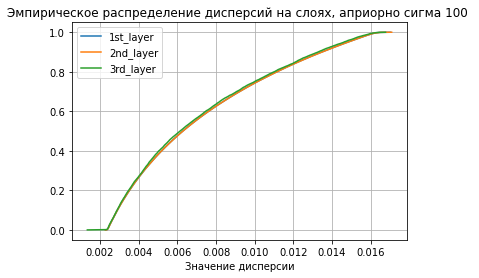

In [47]:
net5 = BBP_Bayes_Net(lr=0.001, channels_in=1, side_in=28, cuda=use_cuda, classes=10, batch_size=batch_size,
                        Nbatches=(NTrainPointsMNIST / batch_size), nhid=1200,
                        prior_instance=isotropic_gauss_prior(mu=0, sigma=sigma5))
models_dir = 'drive/MyDrive/BNN/moddir_5'
net5.load(models_dir + '/theta_last.dat')
state_dict = net5.model.state_dict()
previous_layer_name = ''
layer1weights = torch.zeros(784,1200)
layer2weights = torch.zeros(1200,1200)
layer3weights = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weights += W_mu + 1 * std_w * eps_W
      if(l == 2):
        layer2weights += W_mu + 1 * std_w * eps_W
      if(l == 3):
        layer3weights += W_mu + 1 * std_w * eps_W
layer1weightsmu = layer1weights/10000
layer2weightsmu = layer2weights/10000
layer3weightsmu = layer3weights/10000
layer1weightssigma = torch.zeros(784,1200)
layer2weightssigma = torch.zeros(1200,1200)
layer3weightssigma = torch.zeros(1200,10)
for j in tqdm(range(10000)):
  l = 0
  for key in state_dict.keys():
    layer_name = key.split('.')[0]
    if layer_name != previous_layer_name:
      l += 1
      previous_layer_name = layer_name
      W_mu = state_dict[layer_name + '.W_mu'].data
      W_p = state_dict[layer_name + '.W_p'].data
      std_w = 1e-6 + F.softplus(W_p, beta=1, threshold=20)
      eps_W = W_mu.data.new(W_mu.size()).normal_()
      if(l == 1):
        layer1weightssigma += (W_mu + 1 * std_w * eps_W - layer1weightsmu)*(W_mu + 1 * std_w * eps_W- layer1weightsmu)
      if(l == 2):
        layer2weightssigma += (W_mu + 1 * std_w * eps_W - layer2weightsmu)*(W_mu + 1 * std_w * eps_W- layer2weightsmu)
      if(l == 3):
        layer3weightssigma += (W_mu + 1 * std_w * eps_W - layer3weightsmu)*(W_mu + 1 * std_w * eps_W- layer3weightsmu)
layer1weightssigma = (layer1weightssigma/10000).numpy()
layer2weightssigma = (layer2weightssigma/10000).numpy()
layer3weightssigma = (layer3weightssigma/10000).numpy()
ecdf1 = ECDF(layer1weightssigma.reshape(-1))
ecdf2 = ECDF(layer2weightssigma.reshape(-1))
ecdf3 = ECDF(layer3weightssigma.reshape(-1))
plt.plot(ecdf1.x, ecdf1.y ,label = '1st_layer')
plt.plot(ecdf2.x, ecdf2.y ,label = '2nd_layer')
plt.plot(ecdf3.x, ecdf3.y ,label = '3rd_layer')
plt.title('Эмпирическое распределение дисперсий на слоях, априорно сигма 100 ')
plt.xlabel('Значение дисперсии')
plt.legend()
plt.grid()
plt.show()

Результаты получились странными - одинаковыми для 4 последних априорных значений и отличные от первого. Так как я копировал один и тот же кусок кода с изменением номера модели, я не делаю предположения, что я 1 раз изменил параметры, а 3 раза - нет, да и при перепросмотре я такого не обнаружил. Остается еще один вариант - другие модели просто сошлись к одному и тому же, в то время как первой не хватило пяти эпох. Тем не менее, даже если отталкиваться только от отличающихся графиков - первого и второго - дисперсия параметров будет одного и того же порядка по значениям вне зависимости от начальной инициализации. Также мы замечаем, что дисперсии сходятся к одним и тем же значениям для различных слоев, что ставит под вопрос исходную постановку задачи о зависимости от номера слоя.

Весь предыдущий вывод основан на одной модели. Возможно, при других параметрах эксперимента, например,числе нейронов в скрытых слоях или числе эпох результат был бы другим.